# Sign SGD vector span

Let $A$ be a $m \times n$ feature matrix where $n >> m$ (i.e. the model is overparametrized). If the loss function to minimize is of the form $f(x) = \lVert Ax - b \rVert_2^2$ then for all $t$ $g_t$ is proportional to $A^T(Ax - b)$ and $x_t$ lies in the column vector span of $A^T$. We would like to analyze if sign SGD gives similar results.

In [1]:
%load_ext autoreload
%autoreload 2
%cd ../

C:\Users\Quentin\Documents\semester_3\signSGD-quentin\src


In [2]:
import numpy as np
from numpy import random
from numpy import linalg
import pickle
import pandas as pd

import sklearn
import sklearn.datasets
import scipy

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from utils.convex_opt import MSE, SGD, train_model
from utils.load_datasets import load_abalone, load_gisette, load_e2006, load_artificial

In [3]:
def projection_matrix(A, safe=True):
    # return np.eye(len(A)) #this line makes code run fast by skipping projection computation
    # Computing the raw formula when the matrix is big can be computationally unstable.
    if safe:
        U, S, Vt = linalg.svd(A.T)
        truncate = len(S)
        return np.eye(Vt.shape[0]) - Vt[truncate:, :].T@Vt[truncate:, :]
    else:
        return A@np.linalg.inv(A.T@A)@A.T

In [4]:
def compute_distances(w, X, safe=True, orth=False):
    w = w.squeeze().T
    P = projection_matrix(X.T, safe=safe)
    if orth:
        P = np.eye(P.shape[0]) - P
    projected_w = P@w
    distances = np.linalg.norm(w - projected_w, axis=0)
    return distances

In [5]:
A = np.array([[1, 2, 3, 4], [5, 6, 7, 8]])
A

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [6]:
P1 = projection_matrix(A.T)
P1

array([[ 0.7,  0.4,  0.1, -0.2],
       [ 0.4,  0.3,  0.2,  0.1],
       [ 0.1,  0.2,  0.3,  0.4],
       [-0.2,  0.1,  0.4,  0.7]])

In [7]:
P2 = projection_matrix(A.T, safe=False)
P2

array([[ 0.7,  0.4,  0.1, -0.2],
       [ 0.4,  0.3,  0.2,  0.1],
       [ 0.1,  0.2,  0.3,  0.4],
       [-0.2,  0.1,  0.4,  0.7]])

In [8]:
a = np.array([1, 2, 3, 4])
b = np.array([5, 6, 7, 8])
c = np.array([2, 2, 3, 4])

print(P1@a)
print(P2@a)
print('')
print(P1@b)
print(P2@b)
print('')
print(P1@c)
print(P2@c)

[1. 2. 3. 4.]
[1. 2. 3. 4.]

[5. 6. 7. 8.]
[5. 6. 7. 8.]

[1.7 2.4 3.1 3.8]
[1.7 2.4 3.1 3.8]


## Abalone

Dataset with less features than data points just as a test case.

In [9]:
x_train, y_train, x_test, y_test = load_abalone()

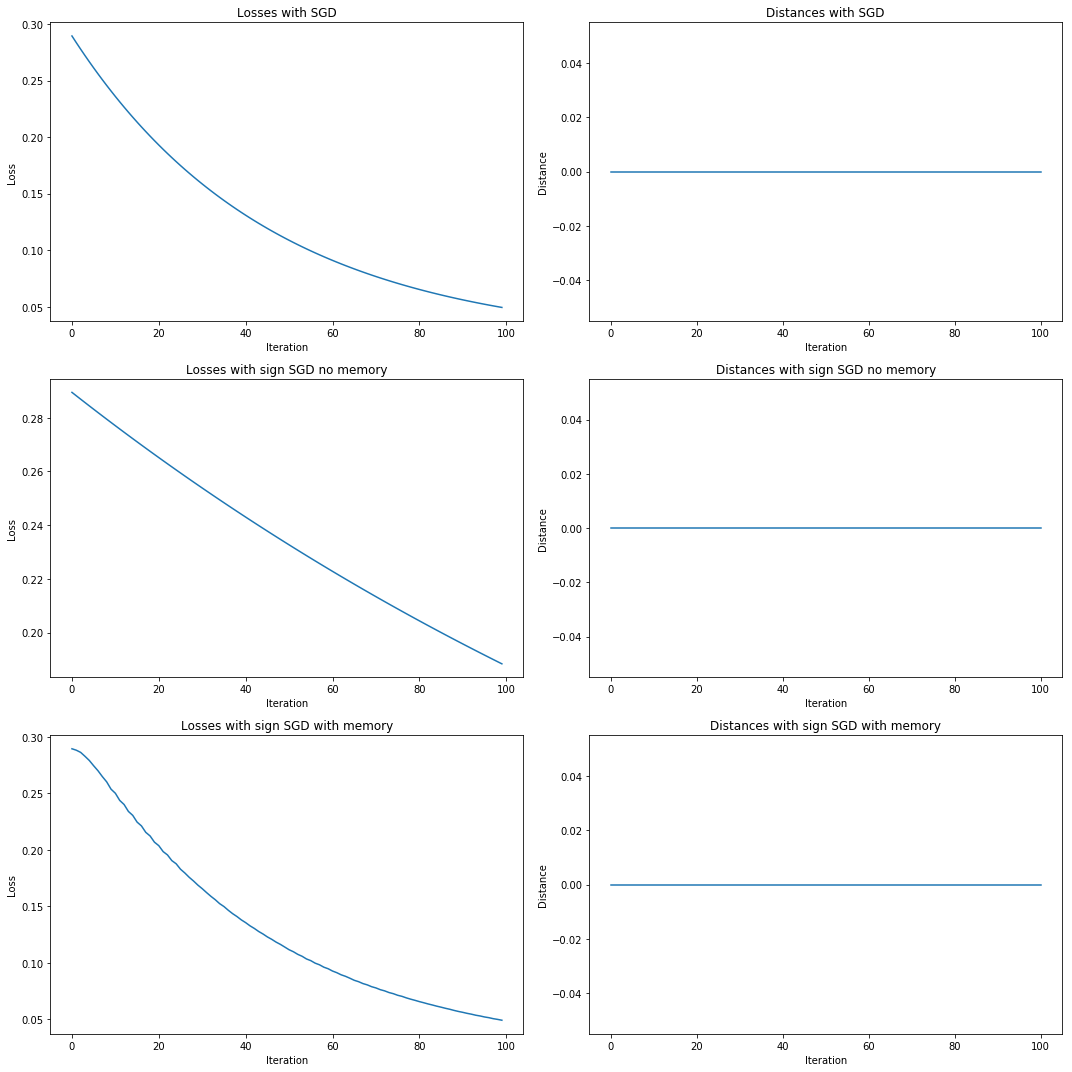

In [10]:
optimizers = [SGD(loss=MSE(), sign=False, memory=False, lr=1e-4),
              SGD(loss=MSE(), sign=True, memory=False, lr=1e-4),
              SGD(loss=MSE(), sign=True, memory=True, lr=1e-4)
             ]
optimizers_names = ['SGD', 'sign SGD no memory', 'sign SGD with memory']

fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(15, 15))

for i, optimizer in enumerate(optimizers):
    res = train_model(x_train, y_train, epochs=100, optimizer=optimizer, batch_size=-1)

    distances = compute_distances(res['w'], x_train)
    ax[i, 0].plot(res['train_losses'])
    ax[i, 1].plot(distances)

    ax[i, 0].set_title('Losses with {}'.format(optimizers_names[i]))
    ax[i, 0].set_xlabel('Iteration')
    ax[i, 0].set_ylabel('Loss')
    ax[i, 1].set_title('Distances with {}'.format(optimizers_names[i]))
    ax[i, 1].set_xlabel('Iteration')
    ax[i, 1].set_ylabel('Distance')

plt.tight_layout()

## Gisette

The number of features in this dataset is large enough to get an overparametrized model.

In [11]:
x_train, y_train, x_test, y_test = load_gisette()

### Using SGD

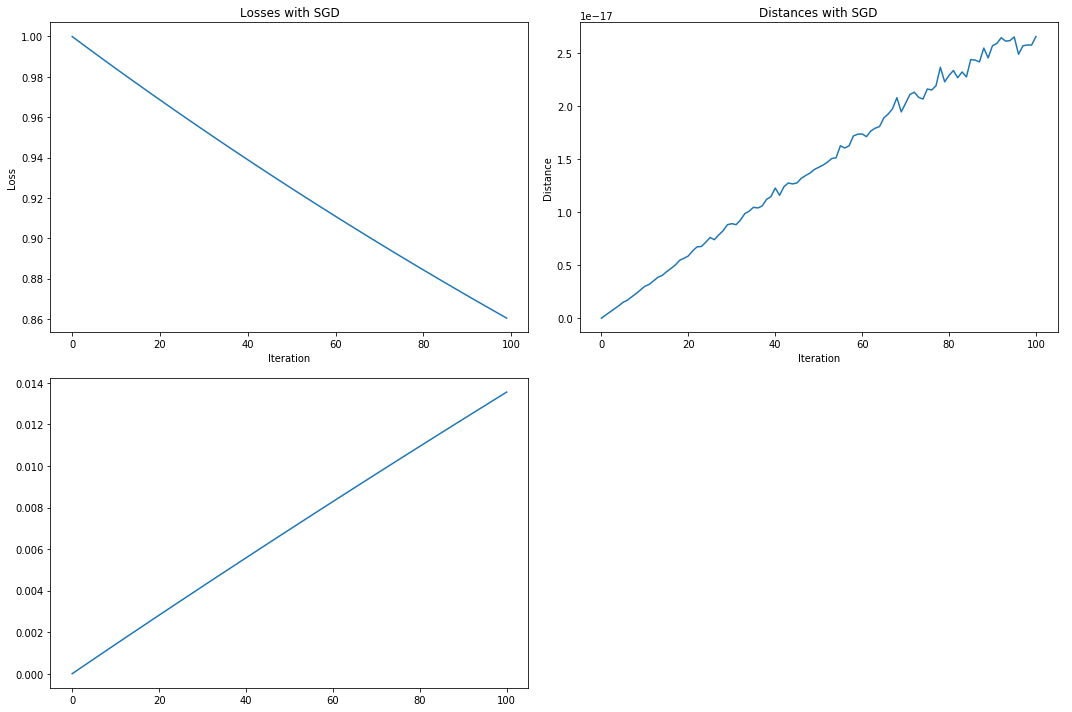

In [14]:
res = train_model(x_train, y_train, lr=1e-4, batch_size=-1)

w_cumavg = np.cumsum(res['w'], axis=0)/np.arange(1, res['w'].shape[0] + 1)[:, np.newaxis, np.newaxis]

distances = compute_distances(res['w'], x_train)
distances_orth = compute_distances(res['w'], x_train, orth=True)
distances_orth = compute_distances(w_cumavg, x_train, orth=True)

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

ax[0, 0].plot(res['train_losses'])
ax[0, 1].plot(distances)
ax[1, 0].plot(distances_orth)
ax[1, 1].axis('off')

ax[0, 0].set_title('Losses with SGD')
ax[0, 0].set_xlabel('Iteration')
ax[0, 0].set_ylabel('Loss')
ax[0, 1].set_title('Distances with SGD')
ax[0, 1].set_xlabel('Iteration')
ax[0, 1].set_ylabel('Distance')

plt.tight_layout()

### Using sign SGD without memory

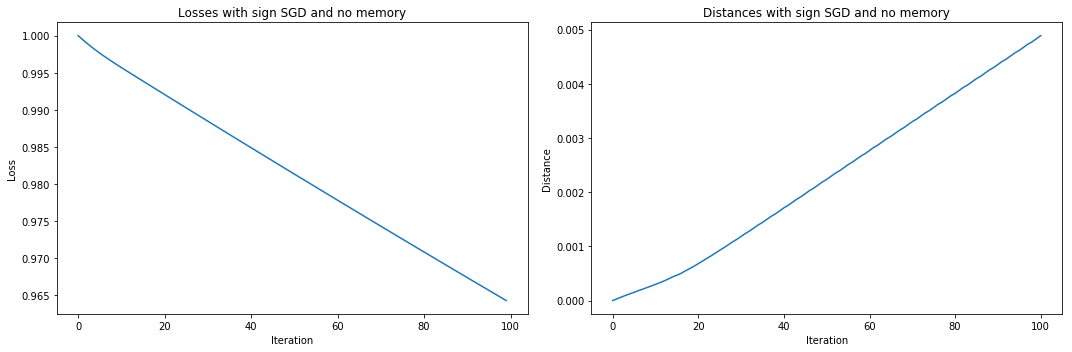

In [15]:
optimizer = SGD(loss=MSE(), sign=True, memory=False, lr=1e-4)
res = train_model(x_train, y_train, optimizer=optimizer, batch_size=-1, epochs=100)

distances = compute_distances(res['w'], x_train)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))

ax[0].plot(res['train_losses'])
ax[1].plot(distances)

ax[0].set_title('Losses with sign SGD and no memory')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Loss')
ax[1].set_title('Distances with sign SGD and no memory')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Distance')

plt.tight_layout()

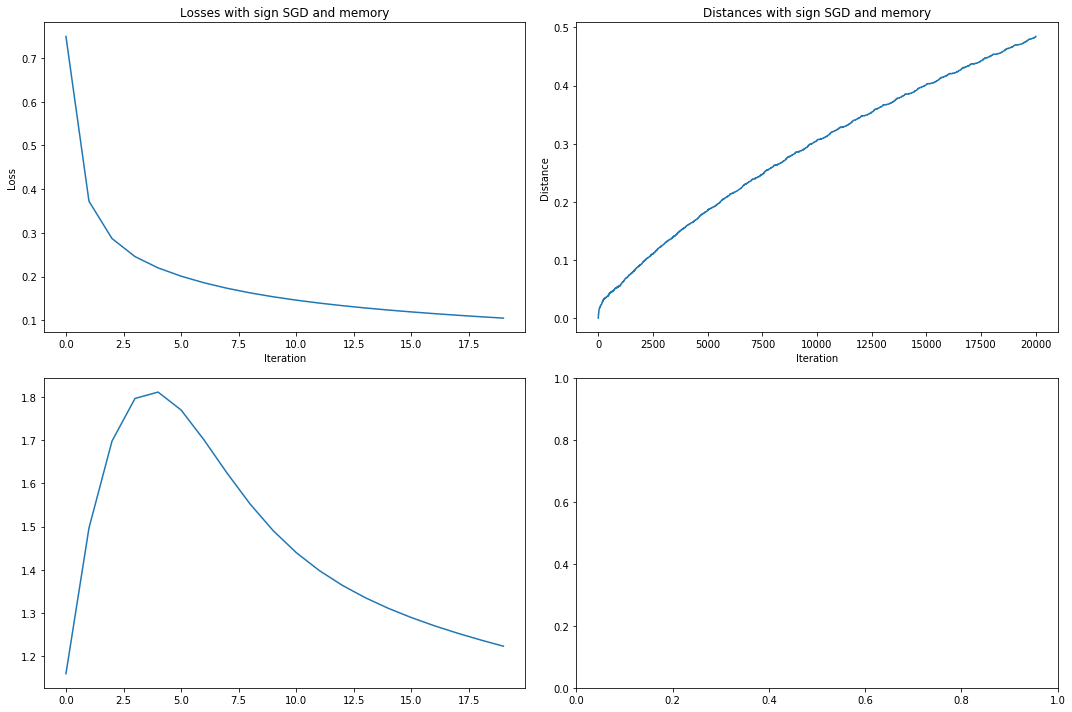

In [12]:
optimizer = SGD(loss=MSE(), sign=True, memory=False, lr=1e-3)
res = train_model(x_train, y_train, x_test=x_test, y_test=y_test, optimizer=optimizer, batch_size=1, epochs=20)

distances = compute_distances(res['w'], x_train)

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

ax[0, 0].plot(res['train_losses'])
ax[0, 1].plot(distances)
ax[1, 0].plot(res['test_losses'])

ax[0, 0].set_title('Losses with sign SGD and memory')
ax[0, 0].set_xlabel('Iteration')
ax[0, 0].set_ylabel('Loss')
ax[0, 1].set_title('Distances with sign SGD and memory')
ax[0, 1].set_xlabel('Iteration')
ax[0, 1].set_ylabel('Distance')

plt.tight_layout()

### Using sign SGD with memory

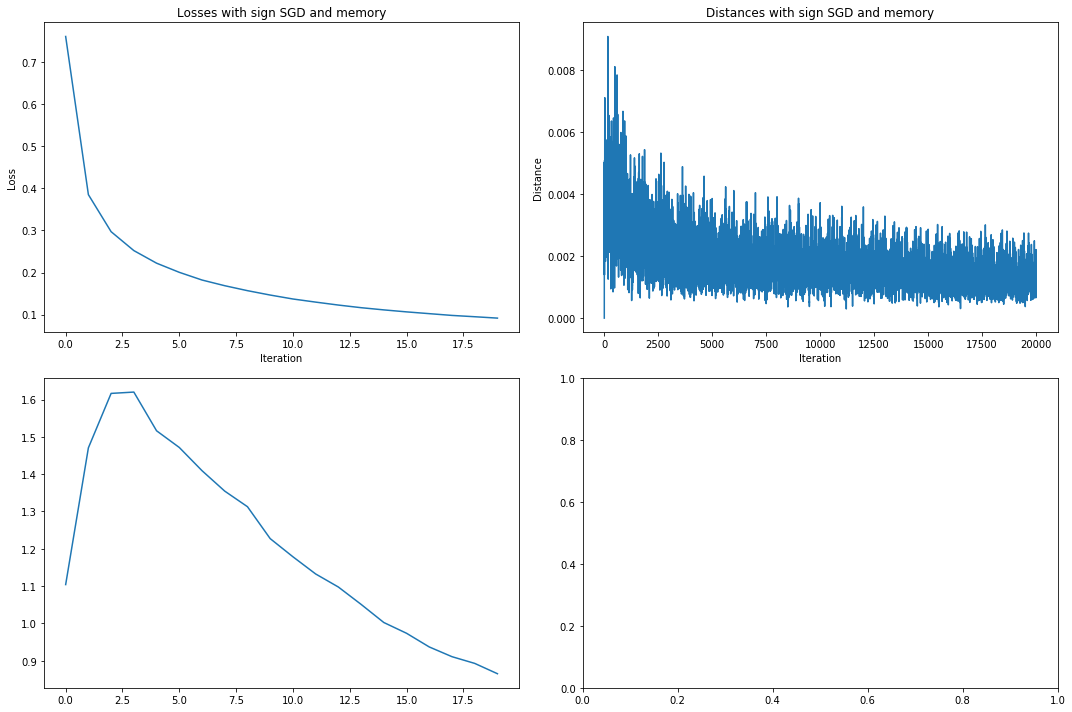

In [13]:
optimizer = SGD(loss=MSE(), sign=True, memory=True, lr=1e-3)
res = train_model(x_train, y_train, x_test=x_test, y_test=y_test, optimizer=optimizer, batch_size=1, epochs=20)

distances = compute_distances(res['w'], x_train)

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

ax[0, 0].plot(res['train_losses'])
ax[0, 1].plot(distances)
ax[1, 0].plot(res['test_losses'])

ax[0, 0].set_title('Losses with sign SGD and memory')
ax[0, 0].set_xlabel('Iteration')
ax[0, 0].set_ylabel('Loss')
ax[0, 1].set_title('Distances with sign SGD and memory')
ax[0, 1].set_xlabel('Iteration')
ax[0, 1].set_ylabel('Distance')

plt.tight_layout()

## E2006

In [9]:
x_train, y_train, x_test, y_test = load_e2006()

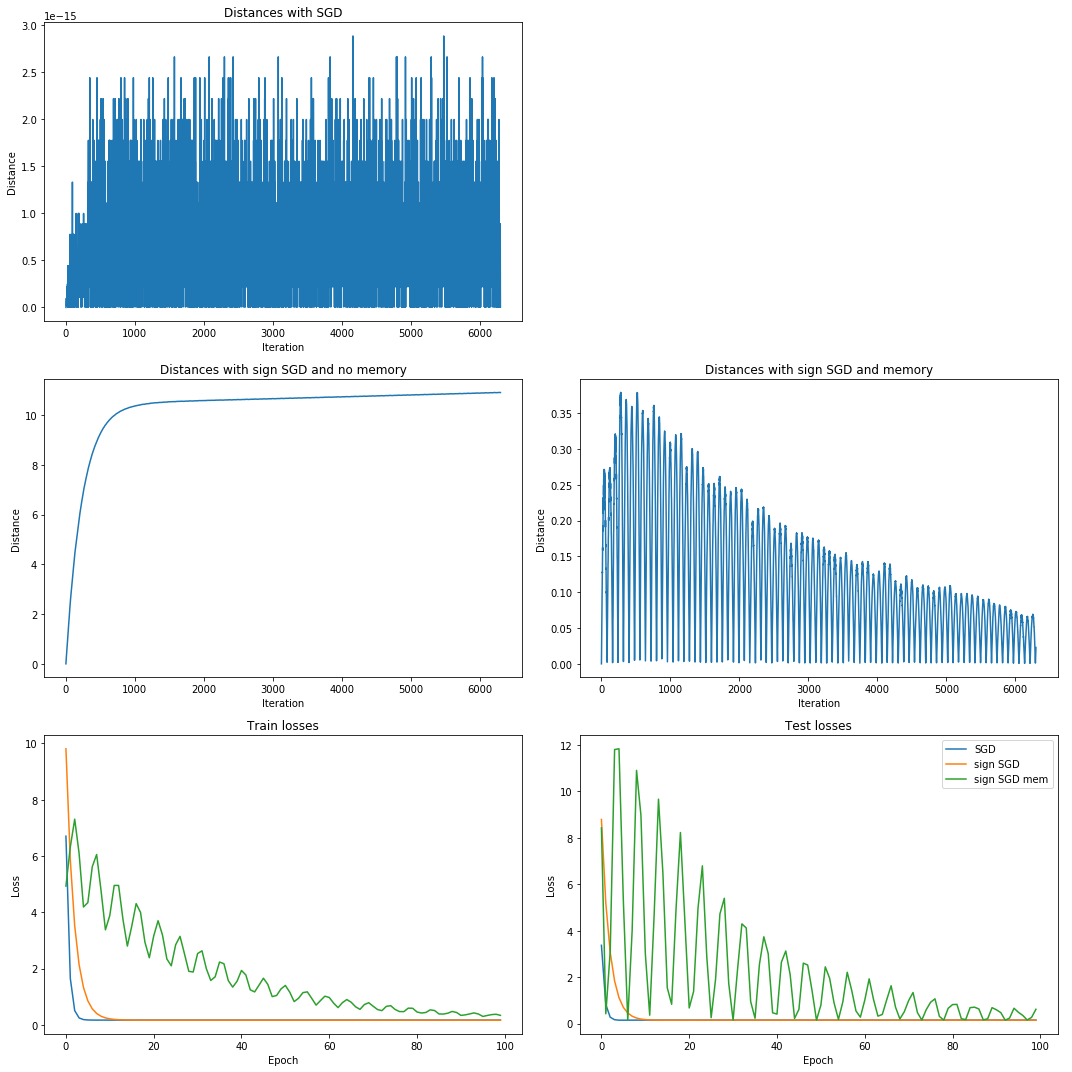

In [14]:
res1 = train_model(x_train, y_train, x_test=x_test, y_test=y_test, lr=1e-3)

optimizer = SGD(loss=MSE(), sign=True, memory=False, lr=0.5)
res2 = train_model(x_train, y_train, x_test=x_test, y_test=y_test, optimizer=optimizer)

optimizer = SGD(loss=MSE(), sign=True, memory=True, lr=1e-1)
res3 = train_model(x_train, y_train, x_test=x_test, y_test=y_test, optimizer=optimizer)

distances1 = compute_distances(res1['w'], x_train)
distances2 = compute_distances(res2['w'], x_train)
distances3 = compute_distances(res3['w'], x_train)

fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(15, 15))

ax[0, 0].plot(distances1)
ax[0, 1].axis('off')
ax[1, 0].plot(distances2)
ax[1, 1].plot(distances3)
ax[2, 0].plot(res1['train_losses'], label='SGD')
ax[2, 0].plot(res2['train_losses'], label='sign SGD')
ax[2, 0].plot(res3['train_losses'], label='sign SGD mem')
ax[2, 1].plot(res1['test_losses'], label='SGD')
plt.legend()
ax[2, 1].plot(res2['test_losses'], label='sign SGD')
ax[2, 1].plot(res3['test_losses'], label='sign SGD mem')

ax[0, 0].set_title('Distances with SGD')
ax[0, 0].set_xlabel('Iteration')
ax[0, 0].set_ylabel('Distance')
ax[1, 0].set_title('Distances with sign SGD and no memory')
ax[1, 0].set_xlabel('Iteration')
ax[1, 0].set_ylabel('Distance')
ax[1, 1].set_title('Distances with sign SGD and memory')
ax[1, 1].set_xlabel('Iteration')
ax[1, 1].set_ylabel('Distance')
ax[2, 0].set_title('Train losses')
ax[2, 0].set_xlabel('Epoch')
ax[2, 0].set_ylabel('Loss')
ax[2, 1].set_title('Test losses')
ax[2, 1].set_xlabel('Epoch')
ax[2, 1].set_ylabel('Loss')

plt.legend()
plt.tight_layout()

# Artificial dataset

In [7]:
# x_train, y_train, x_test, y_test = load_artificial(n=100)
'''Once every 2-3 times the graph looks like below. 
    Saving this instance and loading from pickle instead.
    Probably better to figure out why this is caused 
    and fix the data generation process.
'''
# EDIT PATH!! depending to where jupyter command is run.
filename = "results/gradient-span-artificial-data/artificial_data"
with open(filename+'_x_train.pkl', 'rb') as f:
    x_train = pickle.load(f)
with open(filename+'_x_test.pkl', 'rb') as f:
    x_test = pickle.load(f)
with open(filename+'_y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open(filename+'_y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)    


In [8]:
epochs = 80
res1 = train_model(x_train, y_train, x_test=x_test, y_test=y_test, lr=0.5, epochs=epochs, batch_size=-1)

optimizer = SGD(loss=MSE(), sign=True, memory=False,  lr=10)
res2 = train_model(x_train, y_train, x_test=x_test, y_test=y_test, optimizer=optimizer, epochs=epochs, batch_size=-1)

optimizer = SGD(loss=MSE(), sign=True, memory=True, lr=10)
res3 = train_model(x_train, y_train, x_test=x_test, y_test=y_test, optimizer=optimizer, epochs=epochs, batch_size=-1)

optimizer = SGD(loss=MSE(), sign=True, scale=False, memory=False, momentum=0.1, lr=0.05)
res4 = train_model(x_train, y_train, x_test=x_test, y_test=y_test, optimizer=optimizer, epochs=epochs, batch_size=-1)


distances1 = compute_distances(res1['w'], x_train)
distances2 = compute_distances(res2['w'], x_train)
distances3 = compute_distances(res3['w'], x_train)
distances4 = compute_distances(res4['w'], x_train)

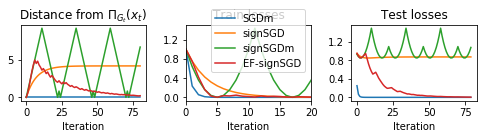

In [15]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(7, 2))
lines = []
labels = []
lines.append(ax[0].plot(distances1, label='SGDm')[0])
labels.append('SGDm')
lines.append(ax[0].plot(distances2, label='signSGD')[0])
labels.append('signSGD')
lines.append(ax[0].plot(distances4, label='signSGDm')[0])
labels.append('signSGDm')
lines.append(ax[0].plot(distances3, label='EF-signSGD')[0])
labels.append('EF-signSGD')

# train_losses
lines.append(ax[1].plot(res1['train_losses'], label='SGDm'))
labels.append('SGDm')
lines.append(ax[1].plot(res2['train_losses'], label='signSGD'))
labels.append('signSGD')
lines.append(ax[1].plot(res4['train_losses'], label='signSGDm'))
labels.append('signSGDm')
lines.append(ax[1].plot(res3['train_losses'], label='EF-signSGD'))
labels.append('EF-signSGD')

# test_losses
lines.append(ax[2].plot(res1['test_losses'], label='SGDm'))
labels.append('SGDm')
lines.append(ax[2].plot(res2['test_losses'], label='signSGD'))
labels.append('signSGD')
lines.append(ax[2].plot(res4['test_losses'], label='signSGDm'))
labels.append('signSGDm')
lines.append(ax[2].plot(res3['test_losses'], label='EF-signSGD'))
labels.append('EF-signSGD')

ax[0].set_title('Distance from $\Pi_{G_t}(x_t)$')
ax[0].set_xlabel('Iteration')
# ax[0].set_ylabel('Distance from linear span of gradients')
ax[1].set_title('Train losses')
ax[1].set_xlabel('Iteration')
ax[1].set_xlim([0,20])
ax[1].set_yticks(np.arange(0., 1.6, 0.4))
ax[2].set_title('Test losses')
ax[2].set_xlabel('Iteration')
ax[2].set_yticks(np.arange(0., 1.6, 0.4),[])
fig.legend(lines, labels, loc = (0.432, 0.48))
fig.savefig('../figs/linear_span_main.pdf', bbox_inches='tight')
plt.tight_layout()

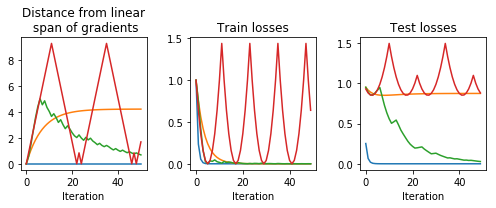

In [22]:
epochs = 50
res1 = train_model(x_train, y_train, x_test=x_test, y_test=y_test, lr=0.5, epochs=epochs, batch_size=-1)

optimizer = SGD(loss=MSE(), sign=True, memory=False,  lr=10)
res2 = train_model(x_train, y_train, x_test=x_test, y_test=y_test, optimizer=optimizer, epochs=epochs, batch_size=-1)

optimizer = SGD(loss=MSE(), sign=True, memory=True, lr=10)
res3 = train_model(x_train, y_train, x_test=x_test, y_test=y_test, optimizer=optimizer, epochs=epochs, batch_size=-1)

optimizer = SGD(loss=MSE(), sign=True, scale=False, memory=False, momentum=0.9, lr=0.05)
res4 = train_model(x_train, y_train, x_test=x_test, y_test=y_test, optimizer=optimizer, epochs=epochs, batch_size=-1)


distances1 = compute_distances(res1['w'], x_train)
distances2 = compute_distances(res2['w'], x_train)
distances3 = compute_distances(res3['w'], x_train)
distances4 = compute_distances(res4['w'], x_train)

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(7, 3))
ax[0].plot(distances1, label='SGD')
ax[0].plot(distances2, label='SignSGD')
ax[0].plot(distances3, label='SSGDF')
ax[0].plot(distances4, label='Signum')
ax[1].plot(res1['train_losses'], label='SGD')
ax[1].plot(res2['train_losses'], label='SignSGD')
ax[1].plot(res3['train_losses'], label='SSGDF')
ax[1].plot(res4['train_losses'], label='Signum')
ax[2].plot(res1['test_losses'], label='SGD')
ax[2].plot(res2['test_losses'], label='SignSGD')
ax[2].plot(res3['test_losses'], label='SSGDF')
ax[2].plot(res4['test_losses'], label='Signum')

ax[0].set_title('Distance from linear\n span of gradients')
ax[0].set_xlabel('Iteration')
# ax[0].set_ylabel('Distance from linear span of gradients')
ax[1].set_title('Train losses')
ax[1].set_xlabel('Iteration')
ax[2].set_title('Test losses')
ax[2].set_xlabel('Iteration')


plt.tight_layout()

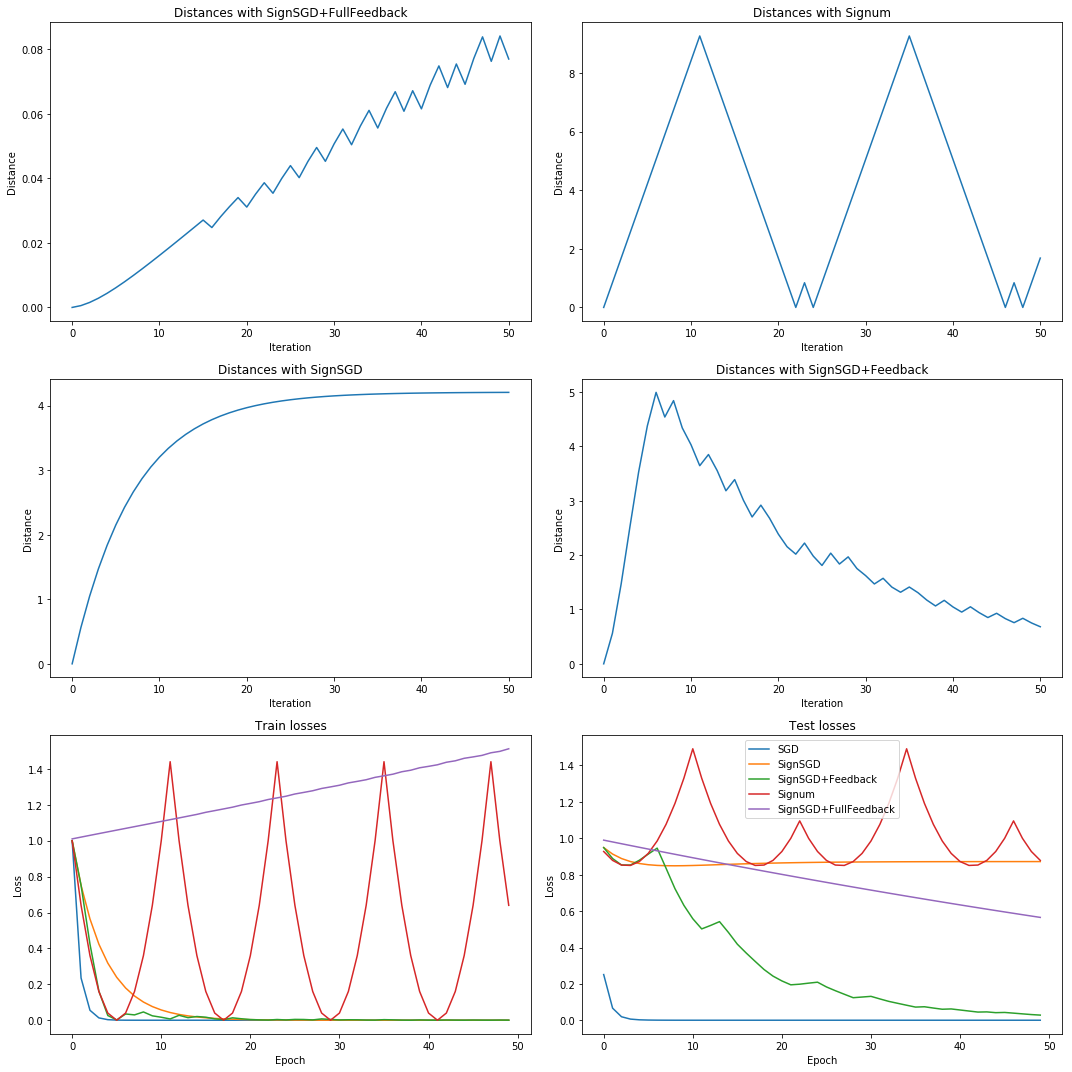

In [6]:
epochs = 50
res1 = train_model(x_train, y_train, x_test=x_test, y_test=y_test, lr=0.5, epochs=epochs, batch_size=-1)

optimizer = SGD(loss=MSE(), sign=True, memory=False,  lr=10)
res2 = train_model(x_train, y_train, x_test=x_test, y_test=y_test, optimizer=optimizer, epochs=epochs, batch_size=-1)

optimizer = SGD(loss=MSE(), sign=True, memory=True, lr=10)
res3 = train_model(x_train, y_train, x_test=x_test, y_test=y_test, optimizer=optimizer, epochs=epochs, batch_size=-1)

optimizer = SGD(loss=MSE(), sign=True, scale=False, memory=False, momentum=0.9, lr=0.05)
res4 = train_model(x_train, y_train, x_test=x_test, y_test=y_test, optimizer=optimizer, epochs=epochs, batch_size=-1)

optimizer = SGD(loss=MSE(), sign=True, memory=True, lr=0.0050)
res5 = train_model(x_train, y_train, x_test=x_test, y_test=y_test, optimizer=optimizer, epochs=epochs,
                   batch_size=-1, fully_corrective=True)

distances5 = compute_distances(res5['w'], x_train)
distances2 = compute_distances(res2['w'], x_train)
distances3 = compute_distances(res3['w'], x_train)
distances4 = compute_distances(res4['w'], x_train)

fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(15, 15))

ax[0, 0].plot(distances5)
ax[0, 1].plot(distances4)
ax[1, 0].plot(distances2)
ax[1, 1].plot(distances3)
ax[2, 0].plot(res1['train_losses'], label='SGD')
ax[2, 0].plot(res2['train_losses'], label='SignSGD')
ax[2, 0].plot(res3['train_losses'], label='SignSGD+Feedback')
ax[2, 0].plot(res4['train_losses'], label='Signum')
ax[2, 0].plot(res5['train_losses'], label='SignSGD+FullFeedback')
ax[2, 1].plot(res1['test_losses'], label='SGD')
plt.legend()
ax[2, 1].plot(res2['test_losses'], label='SignSGD')
ax[2, 1].plot(res3['test_losses'], label='SignSGD+Feedback')
ax[2, 1].plot(res4['test_losses'], label='Signum')
ax[2, 1].plot(res5['test_losses'], label='SignSGD+FullFeedback')

ax[0, 0].set_title('Distances with SignSGD+FullFeedback')
ax[0, 0].set_xlabel('Iteration')
ax[0, 0].set_ylabel('Distance')
ax[0, 1].set_title('Distances with Signum')
ax[0, 1].set_xlabel('Iteration')
ax[0, 1].set_ylabel('Distance')
ax[1, 0].set_title('Distances with SignSGD')
ax[1, 0].set_xlabel('Iteration')
ax[1, 0].set_ylabel('Distance')
ax[1, 1].set_title('Distances with SignSGD+Feedback')
ax[1, 1].set_xlabel('Iteration')
ax[1, 1].set_ylabel('Distance')
ax[2, 0].set_title('Train losses')
ax[2, 0].set_xlabel('Epoch')
ax[2, 0].set_ylabel('Loss')
ax[2, 1].set_title('Test losses')
ax[2, 1].set_xlabel('Epoch')
ax[2, 1].set_ylabel('Loss')

plt.legend()
plt.tight_layout()

**Conclusion**: For the bad example above, even after tuning the learning rates SignSGD and Signum are i) slower than SGD and SignSGD+Feedback, and ii) do not generalize (best test loss > 0.7). Adding fullfeedback offline does make the iterate in the span of layers, but does not seem to be a very good algorithm - though it does converge to zero test loss, its oscillations have a large magnitude. Overall SignSGD+Feedback seems to be the best algorithms.

I would put the full-feedback algorithm only in Appendix. Seems like a bad algorithm. Also its interesting ho

In [34]:
x_train.dump(filename+'_x_train.pkl')
x_test.dump(filename+'_x_test.pkl')
y_train.dump(filename+'_y_train.pkl')
y_test.dump(filename+'_y_test.pkl')    

In [32]:
x_train, y_train, x_test, y_test = load_artificial(n=100)